In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
# sys.path.append(os.path.abspath(os.path.join('../utils')))
sys.path.append('../')

import cv2
import time
import json
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from utils.datagenerator import OpenEDS
from metrics import *
from utils.utils import load_image
from imutils.paths import list_files
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras_fc_densenet import _create_fc_dense_net
from dense10_segmentator import DenseSegmentator
from tensorflow.keras import backend as K

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# dynamically grow GPU memory
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

/home/choppy/TOC/.conda/envs/fb_iris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/choppy/TOC/.conda/envs/fb_iris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/choppy/TOC/.conda/envs/fb_iris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/choppy/TOC/.conda/envs/fb_iris/lib

In [2]:
def class_mean_iou(pred, label, class_info=None):
    pred = np.argmax(pred, axis=-1)
    label = np.argmax(label, axis=-1)
    unique_labels = np.unique(label)
    num_unique_labels = len(unique_labels)

    I = np.zeros(num_unique_labels)
    U = np.zeros(num_unique_labels)
    
    class_iou = []
    
    for index, val in enumerate(unique_labels):
        pred_i = pred == val
        label_i = label == val

        I[index] = float(np.sum(np.logical_and(label_i, pred_i)))
        U[index] = float(np.sum(np.logical_or(label_i, pred_i)))
        class_iou.append(np.mean(I[index] / U[index]))

    if not class_info:
        return np.mean(class_iou), np.std(class_iou)
    else:
        dict_class_iou = dict()
        # class_info: list of dicts
        # [{'source': 'eye', 'id': 0, 'name': 'bg'},
        # {'source': 'eye', 'id': 1, 'name': 'iris'},
        # {'source': 'eye', 'id': 1, 'name': 'pupil'}]
        _ids = [x['id'] for x in class_info]
        _classes = [x['name'] for x in class_info]
        
        if np.all(_ids == unique_labels):
            for lb_id, lb_class in zip(unique_labels, _classes):
                dict_class_iou[lb_class] = class_iou[lb_id]

        else:
            seen_classes = []
            for idx, lb_id in enumerate(unique_labels):
                lb_class = _classes[lb_id]
                seen_classes.append(lb_id)
                dict_class_iou[lb_class] = class_iou[idx]
            
            # not segmented classes cuz there is no class in image. 
            # Append 1.0
            for lb_id in _ids:
                if lb_id in seen_classes: continue
                lb_class = _classes[lb_id]
                dict_class_iou[lb_class] = 0.0
                class_iou.append(0.0)
        
        dict_class_iou['miou'] = np.mean(class_iou)
        dict_class_iou['stdiou'] = np.std(class_iou)
        
        return dict_class_iou

def class_mean_iou_old(pred, label):
    pred = np.argmax(pred, axis=-1)
    label = np.argmax(label, axis=-1)
    unique_labels = np.unique(label)
    num_unique_labels = len(unique_labels)

    I = np.zeros(num_unique_labels)
    U = np.zeros(num_unique_labels)
    class_iou = []
    
    for index, val in enumerate(unique_labels):
        pred_i = pred == val
        label_i = label == val

        I[index] = float(np.sum(np.logical_and(label_i, pred_i)))
        U[index] = float(np.sum(np.logical_or(label_i, pred_i)))
        class_iou.append(np.mean(I[index] / U[index]))

    dict_class_iou = {
        'bg': class_iou[0],
        'iris': class_iou[1],
        'pupil': class_iou[2],
        'sclera': class_iou[3],
        'miou': np.mean(class_iou),
        'stdiou:': np.std(class_iou)
    }
    
    return dict_class_iou

In [3]:
inifile_path = '../config/segmentator_dense10.ini'
modelpath = '../models/epoch_124_miou_0.9345.h5'

model = DenseSegmentator(modelpath=modelpath, inifile_path=inifile_path)
K.set_learning_phase(0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
ths = 0.7
dim = model.target_size[::-1]
dataset_dir = "/home/choppy/TOC/datasets/openeds/ttv"

Dataset = OpenEDS # select class to get intended dataset

testG = Dataset(batch_size=1, dim=dim)
testG.load_eyes(dataset_dir, "test")
testG.prepare()

valG = Dataset(batch_size=1, dim=dim)
valG.load_eyes(dataset_dir, "val")
valG.prepare()

Loading test images: 2264it [00:04, 552.40it/s]
Loading val images: 2264it [00:04, 556.19it/s]


In [6]:
im, lb = testG[0]
im.shape, lb.shape

((1, 320, 240, 3), (1, 320, 240, 4))

# Model Info

In [7]:
# model.summary()

In [8]:
f'{model.count_params():,}'

'210,732'

# Pred one image

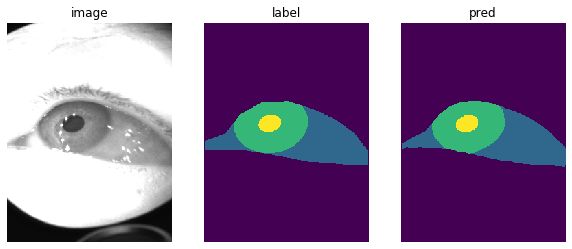

In [9]:
rows = 1
columns = 3

fig = plt.figure(figsize=(10, 8))
im, lb = testG[np.random.choice(len(testG))]
pred = model.predict(im[0])

fig.add_subplot(rows, columns, 1)
plt.title('image')
plt.axis('off')
plt.imshow(im[0])

fig.add_subplot(rows, columns, 2)
plt.title('label')
plt.axis('off')
plt.imshow(np.argmax(lb[0], axis=-1))

fig.add_subplot(rows, columns, 3)
plt.title('pred')
plt.axis('off')
plt.imshow(np.argmax(pred, axis=-1))

plt.show()

In [10]:
len(testG.image_info)

2264

In [11]:
im, lb = testG[np.random.choice(len(testG))]
pred = model.predict(im[0])

pupil_id = next(a['id'] for a in testG.class_info if a['name'] == 'pupil')
p = np.argmax(pred, axis=-1)
pupil_pred = np.where(p == pupil_id, 1., 0.)
pupil_lb = lb[0, ..., 2]

euc_dist, r_diff = distance_error(pupil_lb, pupil_pred)
euc_dist, r_diff

(3.605551275463989, 44)

In [12]:
def get_distance_error(output_image, lb):
    # lb_argmax = np.argmax(output_image, axis=-1)
    pupil_lb = lb[0, ..., pupil_id]
    # pupil_pred = np.where(lb_argmax == pupil_id, 1., 0.)
    pupil_pred = np.where(output_image[..., pupil_id] > ths, 1., 0.)
    derror = distance_error(pupil_lb, pupil_pred)
    return derror

# Evaluate final IoU of val set

In [13]:
val_iou = []
pupil_id = next(a['id'] for a in valG.class_info if a['name'] == 'pupil')

for i in tqdm(range(len(valG)), desc='val set'):
    fname = valG.image_info[i]['path']
    im, lb = valG[i]
    start = time.time()
    output_image = model.predict(im[0])
    end = time.time()

    iou = class_mean_iou(output_image, lb[0, ...], valG.class_info)
    val_iou.append({
        'fname': fname,
        'miou': iou['miou'],
        'inf_time': end-start,
        '_classes': { c['name']: iou[c['name']] for c in valG.class_info },
    })

miou = np.mean([elem['miou'] for elem in val_iou])
std_iou = np.std([elem['miou'] for elem in val_iou])

_cls_iou = {
	c['name']: [ elem['_classes'][c['name']] for elem in val_iou ] for c in valG.class_info
}

print(f'mean iou: {miou}')
print(f'std iou: {std_iou}\n')

for c in _cls_iou:
	print(f'miou {c}: {np.mean(_cls_iou[c])}')
	print(f'std {c}: {np.std(_cls_iou[c])}\n')

val set: 100%|██████████| 2264/2264 [02:31<00:00, 14.90it/s]

mean iou: 0.934193478145915
std iou: 0.05288639486652926

miou bg: 0.9920777797532623
std bg: 0.004038520261270847

miou sclera: 0.8973028060645231
std sclera: 0.06109522555842786

miou iris: 0.9372240731549016
std iris: 0.05967355252200299

miou pupil: 0.9101692536109734
std pupil: 0.11550466956228787



In [14]:
d2 = Dataset(batch_size=1, dim=dim)
d2.load_eyes(dataset_dir, "test")
d2.prepare()

d3 = Dataset(batch_size=1, dim=dim)
d3.load_eyes(dataset_dir, "val")
d3.prepare()

generators = [
	(d2, 'test'), 
	(d3, 'val'),
]

all_iou = [
    # { 
    # fname: str
    # miou: float,
    # coords_pupil: tuple(x, y, r)
    # inf_time: float
    # _classes: dict with:
        # bg: float
        # sclera: float
        # iris: float
        # pupil: float
    # }
]

Loading test images: 2264it [00:04, 551.56it/s]
Loading val images: 2264it [00:04, 528.65it/s]


In [15]:
files_with_error = []
pupil_id = next(a['id'] for a in testG.class_info if a['name'] == 'pupil')

for gen, _set in generators:
	for i in tqdm(range(len(gen)), leave=False, desc=f'{_set} set'):
		fname = gen.image_info[i]['path']
		im, lb = gen[i]
		start = time.time()
		output_image = model.predict(im[0])
		end = time.time()
		# for_pupil = np.argmax(output_image, axis=-1)
		# pupil = np.where(for_pupil == pupil_id, True, False)
		pupil = np.where(output_image[..., pupil_id] > ths, True, False)
		try:
			r_pupil = model.get_radio(mask=pupil, rtype=model.rtype) # may raise error if no pupil was detected
			pupil_err = get_distance_error(output_image, lb)
		except ValueError:
			print(f'pupil not detected for image ({i}) {gen.image_info[i]["path"]}')
			files_with_error.append(fname)
			continue # no append info for this image
		iou = class_mean_iou(output_image, lb[0, ...], gen.class_info)
		all_iou.append({
			'fname': fname,
			'set': _set,
			'miou': iou['miou'],
			'coords_pupil': r_pupil,
			'pupil_err': pupil_err,
			'inf_time': end-start,
			'_classes': { c['name']: iou[c['name']] for c in gen.class_info },
		})

test set:   1%|▏         | 32/2264 [00:02<02:35, 14.32it/s]

pupil not detected for image (29) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000002748.png
pupil not detected for image (30) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000002752.png


test set:  33%|███▎      | 758/2264 [00:53<01:44, 14.48it/s]

pupil not detected for image (756) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000112354.png


test set:  34%|███▍      | 768/2264 [00:53<01:43, 14.45it/s]

pupil not detected for image (765) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000112409.png


test set:  34%|███▍      | 772/2264 [00:54<01:43, 14.45it/s]

pupil not detected for image (769) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000115079.png


test set:  36%|███▌      | 812/2264 [00:57<01:40, 14.47it/s]

pupil not detected for image (810) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000120590.png


test set:  37%|███▋      | 848/2264 [00:59<01:41, 13.96it/s]

pupil not detected for image (845) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000126052.png


test set:  38%|███▊      | 870/2264 [01:01<01:36, 14.43it/s]

pupil not detected for image (867) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000126141.png


test set:  39%|███▉      | 890/2264 [01:02<01:37, 14.06it/s]

pupil not detected for image (887) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000128877.png


test set:  42%|████▏     | 958/2264 [01:07<01:30, 14.39it/s]

pupil not detected for image (955) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000142458.png


test set:  43%|████▎     | 976/2264 [01:08<01:29, 14.47it/s]

pupil not detected for image (973) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000145187.png


test set:  55%|█████▍    | 1244/2264 [01:27<01:11, 14.30it/s]

pupil not detected for image (1241) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000185752.png


test set:  59%|█████▊    | 1328/2264 [01:33<01:06, 14.10it/s]

pupil not detected for image (1326) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000196779.png


test set:  62%|██████▏   | 1402/2264 [01:38<01:02, 13.72it/s]

pupil not detected for image (1400) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000207751.png
pupil not detected for image (1401) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000207752.png


test set:  66%|██████▋   | 1504/2264 [01:46<00:56, 13.54it/s]

pupil not detected for image (1502) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000224148.png


test set:  72%|███████▏  | 1630/2264 [01:55<00:46, 13.63it/s]

pupil not detected for image (1628) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000237974.png
pupil not detected for image (1629) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000237975.png


test set:  90%|█████████ | 2040/2264 [02:26<00:16, 13.58it/s]

pupil not detected for image (2038) /home/choppy/TOC/datasets/openeds/ttv/test/images/000000303541.png


val set:   1%|          | 28/2264 [00:02<02:44, 13.57it/s]   

pupil not detected for image (25) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000002747.png


val set:   4%|▎         | 80/2264 [00:05<02:40, 13.58it/s]

pupil not detected for image (78) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000008202.png


val set:   6%|▌         | 136/2264 [00:10<02:35, 13.67it/s]

pupil not detected for image (133) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000016386.png
pupil not detected for image (134) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000016390.png


val set:   7%|▋         | 148/2264 [00:10<02:35, 13.63it/s]

pupil not detected for image (146) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000016447.png


val set:  11%|█         | 252/2264 [00:18<02:30, 13.41it/s]

pupil not detected for image (249) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000030235.png


val set:  30%|██▉       | 674/2264 [00:49<01:56, 13.60it/s]

pupil not detected for image (671) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000093181.png


val set:  33%|███▎      | 758/2264 [00:56<01:50, 13.59it/s]

pupil not detected for image (755) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000104228.png


val set:  35%|███▍      | 788/2264 [00:58<01:48, 13.64it/s]

pupil not detected for image (786) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000112348.png


val set:  35%|███▌      | 794/2264 [00:58<01:47, 13.62it/s]

pupil not detected for image (792) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000112369.png


val set:  39%|███▉      | 884/2264 [01:05<01:40, 13.67it/s]

pupil not detected for image (882) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000126070.png


val set:  40%|███▉      | 898/2264 [01:06<01:41, 13.42it/s]

pupil not detected for image (895) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000128815.png
pupil not detected for image (897) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000128833.png


val set:  41%|████      | 928/2264 [01:08<01:38, 13.54it/s]

pupil not detected for image (925) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000134256.png


val set:  43%|████▎     | 966/2264 [01:11<01:36, 13.46it/s]

pupil not detected for image (964) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000137057.png


val set:  45%|████▌     | 1022/2264 [01:15<01:31, 13.56it/s]

pupil not detected for image (1019) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000147937.png


val set:  46%|████▌     | 1038/2264 [01:16<01:29, 13.67it/s]

pupil not detected for image (1036) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000150644.png


val set:  59%|█████▊    | 1326/2264 [01:38<01:08, 13.61it/s]

pupil not detected for image (1324) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000194001.png


val set:  59%|█████▉    | 1334/2264 [01:38<01:08, 13.59it/s]

pupil not detected for image (1332) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000196700.png


val set:  87%|████████▋ | 1974/2264 [02:26<00:21, 13.58it/s]

pupil not detected for image (1972) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000292510.png


val set:  91%|█████████▏| 2070/2264 [02:33<00:14, 13.57it/s]

pupil not detected for image (2067) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000303551.png


val set:  97%|█████████▋| 2188/2264 [02:42<00:05, 13.45it/s]

pupil not detected for image (2186) /home/choppy/TOC/datasets/openeds/ttv/val/images/000000322685.png


# Evaluation Metrics

In [16]:
len(files_with_error)

41

In [17]:
print(f'Total images: {len(all_iou)}\n')
print(f'Mean Dist error: {np.mean([m["pupil_err"][0] for m in all_iou])}')
print(f'Std Dist error: {np.std([m["pupil_err"][0] for m in all_iou])}')
print(f'Max Dist error: {np.max([m["pupil_err"][0] for m in all_iou])}')
print(f'Min Dist error: {np.min([m["pupil_err"][0] for m in all_iou])}')
print('\n', '-'*40, '\n')
print(f'Mean Radio error: {np.mean([m["pupil_err"][-1] for m in all_iou])}')
print(f'Std Radio error: {np.std([m["pupil_err"][-1] for m in all_iou])}')
print(f'Max Radio error: {np.max([m["pupil_err"][-1] for m in all_iou])}')
print(f'Min Radio error: {np.min([m["pupil_err"][-1] for m in all_iou])}')
print('\n', '-'*40, '\n')
print(f'Mean IoU: {np.mean([m["miou"] for m in all_iou])}')
print(f'Std IoU: {np.std([m["miou"] for m in all_iou])}')
print(f'Min IoU: {np.min([m["miou"] for m in all_iou])}')
print(f'Max IoU: {np.max([m["miou"] for m in all_iou])}')
print(f'Avg time: {np.mean([m["inf_time"] for m in all_iou])}')
print(f'Std time: {np.std([m["inf_time"] for m in all_iou])}')
print('\n', '-'*40, '\n')

for key in all_iou[0]['_classes'].keys():
    print(f'{key} miou: {np.mean([m["_classes"][key] for m in all_iou])}')

Total images: 4487

Mean Dist error: 0.7057962827522074
Std Dist error: 1.344644774748112
Max Dist error: 28.42534080710379
Min Dist error: 0.0

 ---------------------------------------- 

Mean Radio error: 0.6565634053933586
Std Radio error: 0.947915288272086
Max Radio error: 16
Min Radio error: 0

 ---------------------------------------- 

Mean IoU: 0.9376142756272584
Std IoU: 0.03378855722273537
Min IoU: 0.4391433500714519
Max IoU: 0.9730467030910189
Avg time: 0.055736312096810216
Std time: 0.0019163450717620844

 ---------------------------------------- 

bg miou: 0.9922373357688462
sclera miou: 0.8997042434359993
iris miou: 0.9405197182119357
pupil miou: 0.9179958050922523


# Check Radio Errors

### max radio diff

In [18]:
id_m = np.argmax([m["pupil_err"][-1] for m in all_iou])
all_iou[id_m]

{'fname': '/home/choppy/TOC/datasets/openeds/ttv/val/images/000000057513.png',
 'set': 'val',
 'miou': 0.623269139327966,
 'coords_pupil': array([206, 118,  15,  27]),
 'pupil_err': (16.0312195418814, 16),
 'inf_time': 0.056580305099487305,
 '_classes': {'bg': 0.981094408771956,
  'sclera': 0.8398701298701299,
  'iris': 0.6721120186697783,
  'pupil': 0.0}}

### max distance error

In [19]:
id_m = np.argmax([m["pupil_err"][0] for m in all_iou])
all_iou[id_m]

{'fname': '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000183122.png',
 'set': 'test',
 'miou': 0.6760655373208027,
 'coords_pupil': array([128, 128,   5,   5]),
 'pupil_err': (28.42534080710379, 12),
 'inf_time': 0.052785634994506836,
 '_classes': {'bg': 0.9936861423836525,
  'sclera': 0.7639405204460966,
  'iris': 0.8293515358361775,
  'pupil': 0.11728395061728394}}

# Worst Image

In [22]:
d_names = [elem['fname'] for elem in all_iou]
d_set = [elem['set'] for elem in all_iou]
s_iou = [elem['miou'] for elem in all_iou]

In [23]:
min_iou = np.where(np.array(s_iou) == np.min(s_iou))[0][0]
fname_min_iou = d_names[min_iou]
set_min_iou = d_set[min_iou]
set_min_iou, fname_min_iou, min_iou

('test',
 '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000002754.png',
 29)

In [24]:
_miou = s_iou.copy()
_miou = np.sort(_miou)
_miou[:10]

array([0.43914335, 0.46047514, 0.51651267, 0.52288113, 0.56244591,
       0.57252813, 0.58238467, 0.59372934, 0.59501808, 0.60006501])

{'bg': 0.9841150685666028,
 'sclera': 0.42194744976816073,
 'iris': 0.3253119429590018,
 'pupil': 0.025198938992042442,
 'miou': 0.4391433500714519,
 'stdiou': 0.3469861083875975}

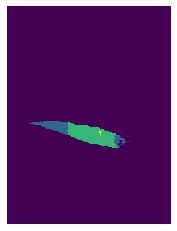

In [26]:
d = [gen[0] for gen in generators if gen[1] == set_min_iou][0]
fname = fname_min_iou.split('/')[-1]
im, lb = d.get_image_by_name(fname)

output_image = model.predict(im[0])
iou = class_mean_iou(output_image, lb[0, ...], d.class_info)
output_image = np.argmax(output_image, axis=-1)

plt.imshow(output_image)
plt.axis('off')
iou

(-0.5, 239.5, 319.5, -0.5)

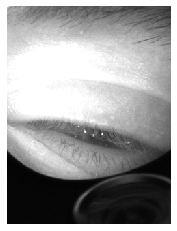

In [27]:
plt.imshow(im[0, ...])
plt.axis('off')

(-0.5, 239.5, 319.5, -0.5)

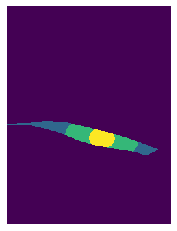

In [28]:
plt.imshow(np.argmax(lb[0, ...], axis=-1))
plt.axis('off')

In [29]:
files_with_error

['/home/choppy/TOC/datasets/openeds/ttv/test/images/000000002748.png',
 '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000002752.png',
 '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000112354.png',
 '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000112409.png',
 '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000115079.png',
 '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000120590.png',
 '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000126052.png',
 '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000126141.png',
 '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000128877.png',
 '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000142458.png',
 '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000145187.png',
 '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000185752.png',
 '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000196779.png',
 '/home/choppy/TOC/datasets/openeds/ttv/test/images/000000207751.png',
 '/hom

# Images with errors

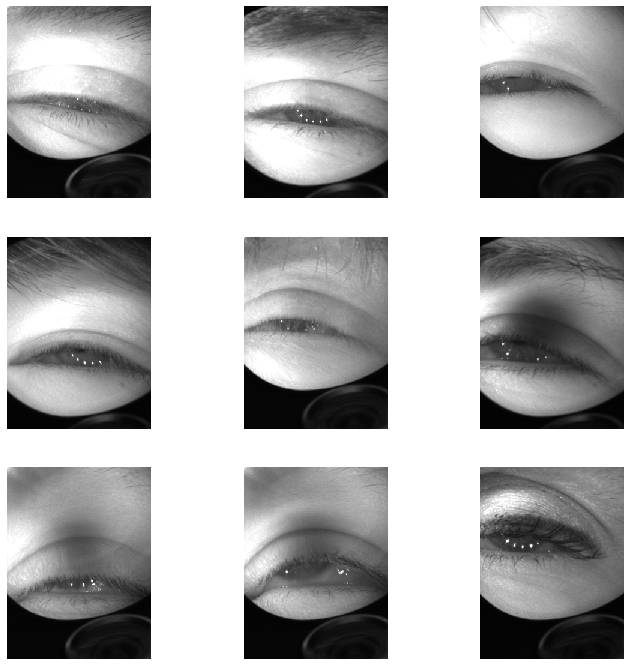

In [30]:
fig = plt.figure(figsize=(12, 12))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    impath = files_with_error[i-1]
    if 'train' in impath: d = d1
    elif 'test' in impath: d = d2
    else: d = d3
    imname = os.path.basename(impath)
    im, lb = d.get_image_by_name(imname)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(im[0])
plt.show()

# Ground Truth

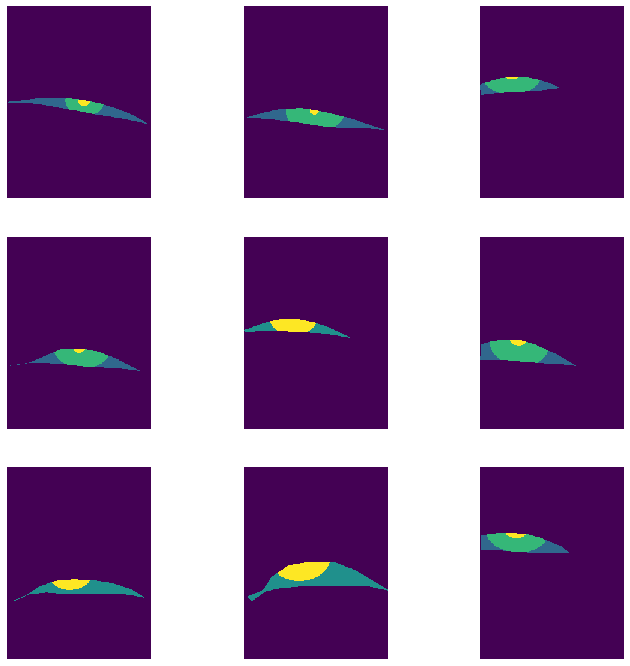

In [31]:
fig = plt.figure(figsize=(12, 12))

for i in range(1, columns*rows +1):
    impath = files_with_error[i-1]
    if 'train' in impath: d = d1
    elif 'test' in impath: d = d2
    else: d = d3
    imname = os.path.basename(impath)
    im, lb = d.get_image_by_name(imname)
    lb = np.argmax(lb[0], axis=-1)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(lb)
plt.show()

# Prediction

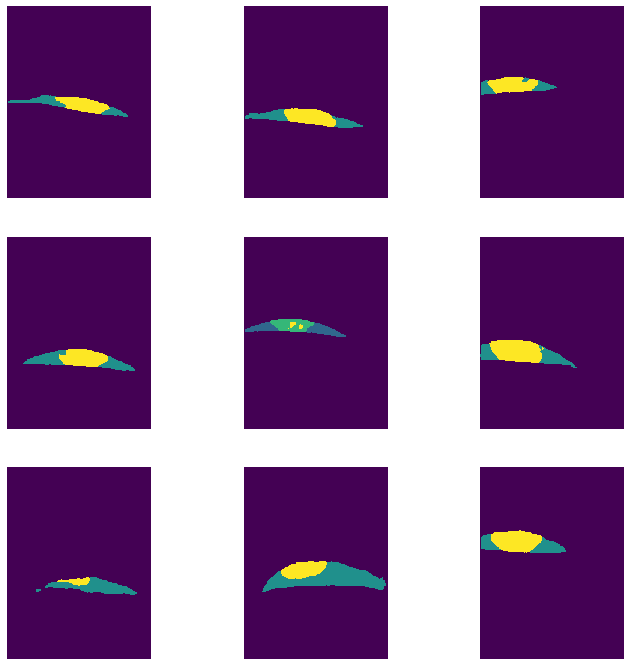

In [32]:
fig = plt.figure(figsize=(12, 12))

for i in range(1, columns*rows +1):
    impath = files_with_error[i-1]
    if 'train' in impath: d = d1
    elif 'test' in impath: d = d2
    else: d = d3
    imname = os.path.basename(impath)
    im, lb = d.get_image_by_name(imname)
    pred = model.predict(im[0])
    pred = np.argmax(pred, axis=-1)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(pred)
plt.show()

bines: 28


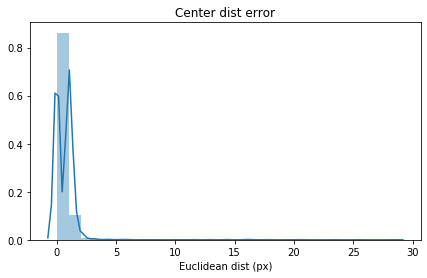

In [33]:
fig = plt.figure(figsize=(7, 4))
plt.title('Center dist error')
dst_err = [elem['pupil_err'][0] for elem in all_iou]
sns.distplot(dst_err, bins=int(max(dst_err)))
# sns.distplot(dst_err, bins=10)
plt.xlabel('Euclidean dist (px)')
print('bines:', int(max(dst_err)))
# sns.distplot(dst_err)

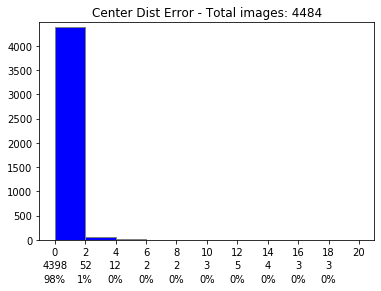

In [34]:
fig, ax = plt.subplots()
data = [elem['pupil_err'][0] for elem in all_iou]
data = np.sort(np.array(data))

if data[-1] > 18:
	data = data[:-3]
	
plt.title(f'Center Dist Error - Total images: {len(data)}')
counts, bins, patches = ax.hist(data, facecolor='blue', edgecolor='gray')

# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins)
ax.set_ylim(0, len(data))
# Set the xaxis's tick labels to be formatted with 1 decimal place...
# ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# Change the colors of bars at the edges...
# twentyfifth, seventyfifth = np.percentile(data, [5, 95])
# for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
#     if rightside < twentyfifth:
#         patch.set_facecolor('red')
#     elif leftside > seventyfifth:
#         patch.set_facecolor('green')

# Label the raw counts and the percentages below the x-axis...
bin_centers = 1e-4 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    ax.annotate(str(int(count)), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')

    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -34), textcoords='offset points', va='top', ha='center')

bines: 16


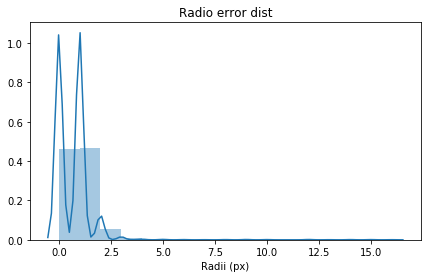

In [35]:
fig = plt.figure(figsize=(7, 4))
plt.title('Radio error dist')
rad_err = [elem['pupil_err'][-1] for elem in all_iou]
sns.distplot(rad_err, bins=int(max(rad_err)))
# sns.distplot(dst_err, bins=10)
plt.xlabel('Radii (px)')
print('bines:', int(max(rad_err)))

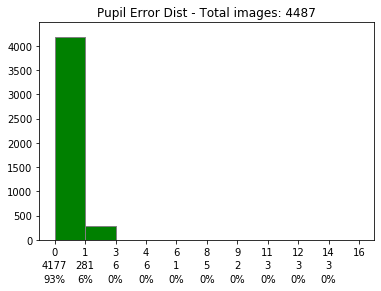

In [36]:
fig, ax = plt.subplots()
data = [elem['pupil_err'][-1] for elem in all_iou]
data = np.sort(np.array(data))

if data[-1] > 20:
	data = data[:-3]

plt.title(f'Pupil Error Dist - Total images: {len(data)}')
counts, bins, patches = ax.hist(data, facecolor='green', edgecolor='gray')

# Set the ticks to be at the edges of the bins.
ax.set_xticks(bins)
ax.set_ylim(0, len(data))
# Set the xaxis's tick labels to be formatted with 1 decimal place...
# ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# Change the colors of bars at the edges...
# twentyfifth, seventyfifth = np.percentile(data, [25, 75])
# for patch, rightside, leftside in zip(patches, bins[1:], bins[:-1]):
#     if rightside < twentyfifth:
#         patch.set_facecolor('red')
#     elif leftside > seventyfifth:
#         patch.set_facecolor('green')

# Label the raw counts and the percentages below the x-axis...
bin_centers = 1e-4 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    ax.annotate(str(int(count)), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -20), textcoords='offset points', va='top', ha='center')

    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -34), textcoords='offset points', va='top', ha='center')